# In vivo recordings

#### **Basic instructions:**
#### 1. **To run code windows/blocks:** 

    - you can either hit the play button to the left of the code window 

    - or you can use they keyboard shortcut: select the block and press 'shift-enter'.

#### 2. **The first time** you run this code notebook, you might get a popup asking to choose which version of Python to use (the python "kernel"). **Just hit enter** to choose the base/default version.

#### 3. Make sure you data (.abf) files are in the "data" folder here on the left. You can just copy/paste the files from where they are saved on your computer.

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *
update_plot_defaults()
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Choose the data file you want to analyze

#### Put the .abf files with your Ih recordings in the "data/13-In_vivo" folder

In [26]:
data_folder = "data/13-In_vivo"

import os
print("Folders:")
for subdir in os.listdir(data_folder):
    if os.path.isdir(data_folder + "/" + subdir):
        print(f"'{data_folder}/{subdir}'")

from glob import glob
print("Files:")
data_files = glob(data_folder+"/*.h5")
data_files.sort()
data_files

Folders:
Files:


['data/13-In_vivo/eric_mp10_2025-06-18_0001.h5',
 'data/13-In_vivo/shannon_MP2_2025-06-17_0001.h5']

Choose which file you want to analyze (copy name from above) and paste the file name here:

In [27]:
data_file = 'data/13-In_vivo/shannon_MP2_2025-06-17_0001.h5'
# data_file = 'data/13-In_vivo/eric_mp10_2025-06-18_0001.h5'

Now we can load the file and plot the raw data:

Trace('shannon_MP2_2025-06-17_0001.h5')
Data points: 16,509,829
Duration: 825.491 s
Sampling rate: 20000 Hz
Sampling interval: 0.050 ms
Available channels: Current, Voltage


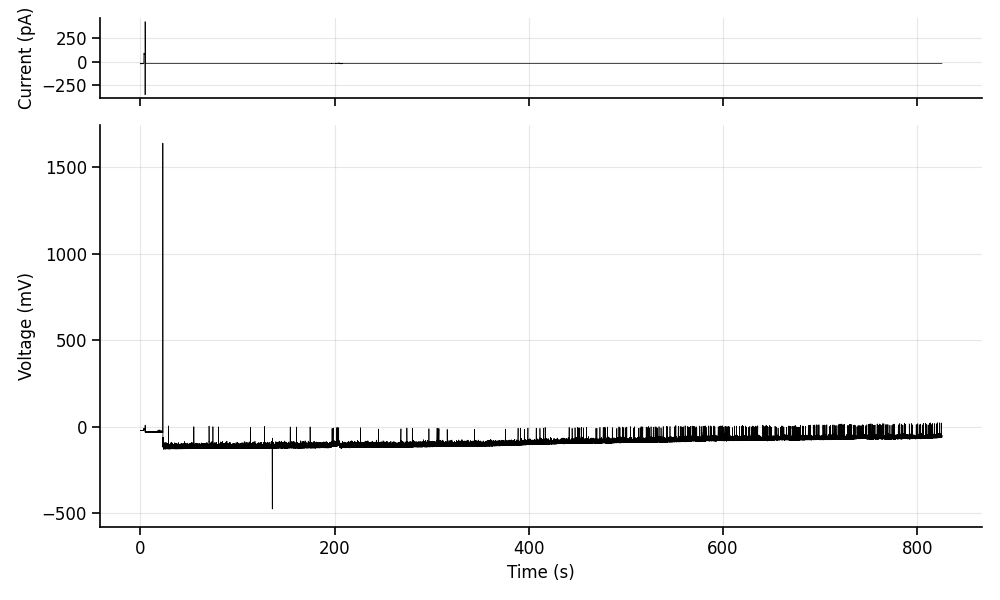

In [28]:
# Load with custom scaling and separate sweeps
traces = Trace.from_wavesurfer_h5_file(data_file, 
                                    current_scaling=0.05,  # Convert to nA
                                    voltage_scaling=0.05,   # Convert to mV
                                    concatenate_sweeps=True)

# traces = traces.resample(sampling_frequency=5000)

print(traces)

time_units = 's' # specify seconds (s), or milliseconds (ms)

# ----------------------------------------------------------------------------------------------------------------
%matplotlib widget
ax = traces.plot(plot_voltage=True, plot_current=True, time_units=time_units, sweep='all', height_ratios=[1, 5])
plt.show()

## 2. Signal processing

### First let's crop out the data we want to analyze (get rid of the initial portion before the recording starts)

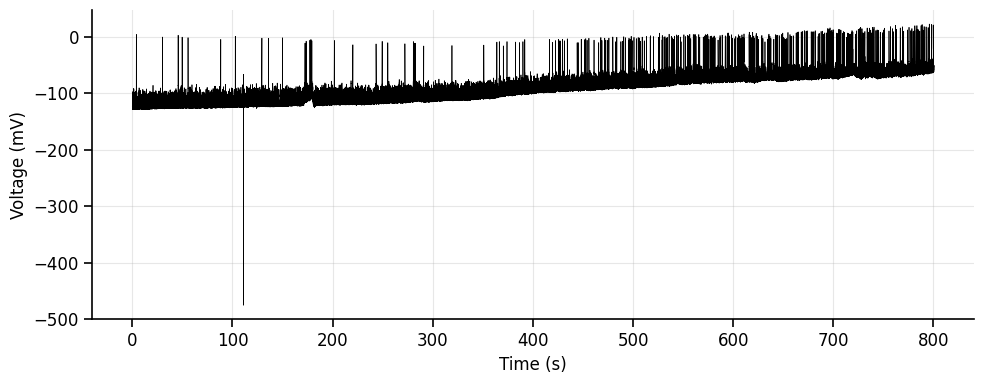

In [29]:
start_time = 25
traces = traces.crop(timepoint=start_time, time_units=time_units)

%matplotlib inline
ax = traces.plot(plot_voltage=True, plot_current=False, time_units=time_units, sweep='all')
plt.show()


### 2.1. Optional: apply highpass / lowpass / bandpass filtering

Depending in you recording, you may have 50/60 Hz line noise, high-frequency noise, or drift in your recordings.

The goal here is to only remove the noise with minimal distortion of the data, so be careful not to overdo it

In [30]:
apply_filtering = True

You can run this next cell as many times as you want to fine-tune the filtering parameters:

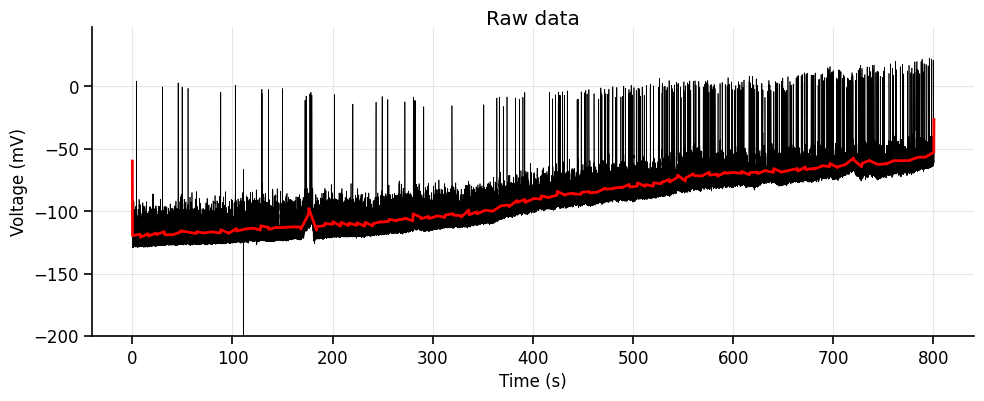

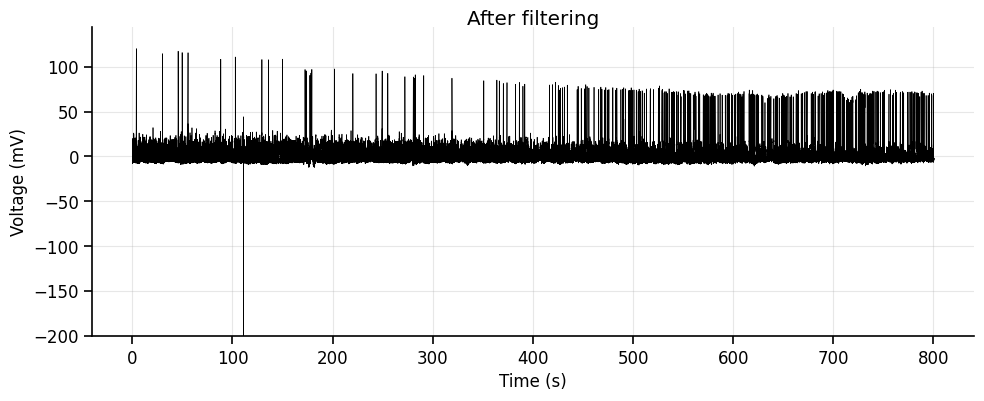

In [31]:
if apply_filtering:
    filtered_traces = traces
    # Step 1: Detrend the data to remove linear or constant trends (e.g slow drift)
    filtered_traces, trend = filtered_traces.detrend(detrend_type='linear', num_segments=100, return_trend=True)

    # Smooth the trend using a boxcar filter
    window_size = 5000
    trend['voltage_trend'] = np.convolve(trend['voltage_trend'], np.ones(window_size)/window_size, mode='same')

    # Step 2: Lowpass filter (removes high-frequency noise)
    filtered_traces = filtered_traces.lowpass_filter(cutoff_freq = 5000, # Choose a value in units of Hz
                                                    apply_to_voltage=True)

    # Step 3: Bandpass filter (removes 50/60 Hz mainline noise)
    filtered_traces = filtered_traces.filter_line_noise(
        line_freq = 60, # Frequency (Hz) of noise to remove: 50 Hz (in Europe) or 60 Hz (in the US).
        width = 0.5, # Width (Hz) controls the width of frequency bands around the line frequency the filter cuts out.
        method = 'notch', # Options: 'notch' (IIR notch filter), 'bandstop' (Butterworth), or 'fft' (spectral).
        apply_to_voltage=True)

    # # # Step 4: Highpass filter (removes low-frequency oscillations)
    # # # ------------------------------------------------------------
    # # # # Be extra careful with this next one, it tends to distort the data. Use only in case of emergency.
    # # filtered_traces = filtered_traces.highpass_filter(cutoff_freq=0.001)
    # # # ------------------------------------------------------------

    %matplotlib inline
    ax = traces.plot(plot_voltage=True, plot_current=False)
    ax.set_title('Raw data', y=0.98)
    ax.plot(traces.time, trend['voltage_trend'], 'r', linewidth=2)
    ax.set_ylim(bottom=-200)
    plt.show()

    ax = filtered_traces.plot(plot_voltage=True, plot_current=False)
    ax.set_title('After filtering', y=0.98)
    ax.set_ylim(bottom=-200)
    plt.show()


Once you are happy with the filter setting, run the next cell to implement them:

In [32]:
if apply_filtering:
    traces=filtered_traces

### 2.2. Optional: apply baseline correction

If your baseline current is not at zero, run the next code blocks to apply a baseline correction.

In [33]:
# Change this to True if you want to subtract the baseline from the sweeps.
subtract_baseline = False
start_baseline = None
end_baseline = None

In [34]:
if subtract_baseline:
    traces.subtract_baseline(start_time = start_baseline, 
                             end_time = end_baseline , 
                             time_units = time_units,  # specify seconds (s), or milliseconds (ms)
                             channel = 'voltage')  # Options: 'current', 'voltage', 'all'
    %matplotlib inline
    ax1, ax2 = traces.plot(plot_voltage=True, plot_ttl=False, time_units=time_units, sweep='all', height_ratios=[1,4])
    ax1.set_title('After baseline subtraction', y=0.98)
    plt.show()
else:
    print("BASELINE NOT SUBTRACTED")


BASELINE NOT SUBTRACTED


## 3. Measure firing rate to get FI curve

In [35]:
spike_results = traces.analyze_action_potentials(min_spike_amplitude=40.0, 
                                                max_width=5.0, 
                                                min_ISI=0.5, 
                                                headstage=0, 
                                                sweep=None, # None means all sweeps
                                                return_dict=True,
                                                time_units='ms')

spike_results

{'spike_times': array([  3998.3 ,   3998.95,   3999.6 , ..., 799879.55, 799880.1 ,
        799880.75]),
 'threshold_voltages': array([30.9186, 30.9835, 30.956 , ..., 15.3284, 15.1863, 15.9812]),
 'peak_voltages': array([118.9107, 118.9107, 118.9107, ...,  70.2556,  70.2556,  70.2556]),
 'spike_amplitudes': array([87.9921, 87.9272, 87.9547, ..., 54.9272, 55.0692, 54.2744]),
 'spike_widths': array([4.75, 4.1 , 3.45, ..., 3.6 , 3.05, 2.35])}

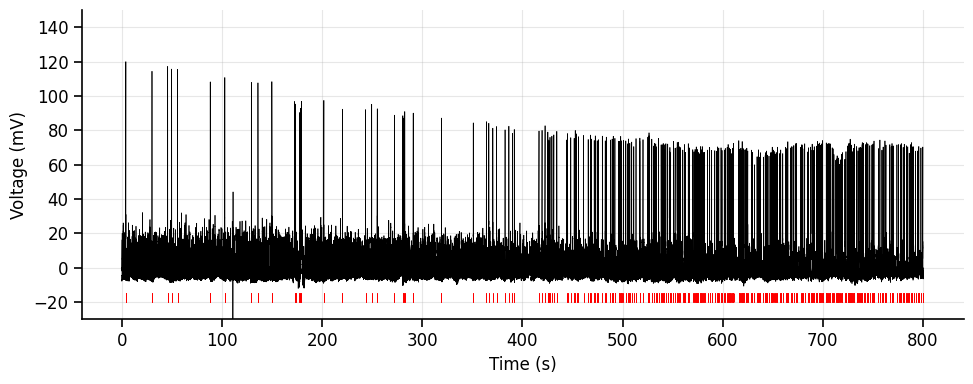

In [36]:
spike_times = spike_results['spike_times'] / 1000
y_axis_range = (-30, 150)

%matplotlib inline
ax = traces.plot(plot_voltage=True, plot_current=False)
# ax.scatter(spike_times, np.ones(len(spike_times))*-15, marker='o', color='r', s=10, zorder=10)
ax.vlines(spike_times, -20, -15, color='r', linewidth=0.7)

ax.set_ylim(y_axis_range)
plt.show()

In [ ]:
duration = traces.total_time
sampling_rate = traces.sampling_rate
time, firing_rate = compute_firing_rate(spike_times, duration, sampling_rate, sigma_ms=sampling_rate)


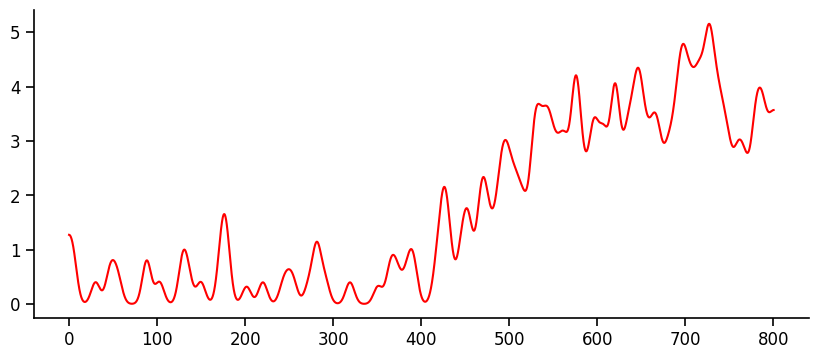

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(time,firing_rate, color='b')
plt.show()

In [ ]:
trend['voltage_trend'].shape

(16009828,)

In [ ]:
firing_rate.shape

(800491,)

TypeError: unhashable type: 'dict'

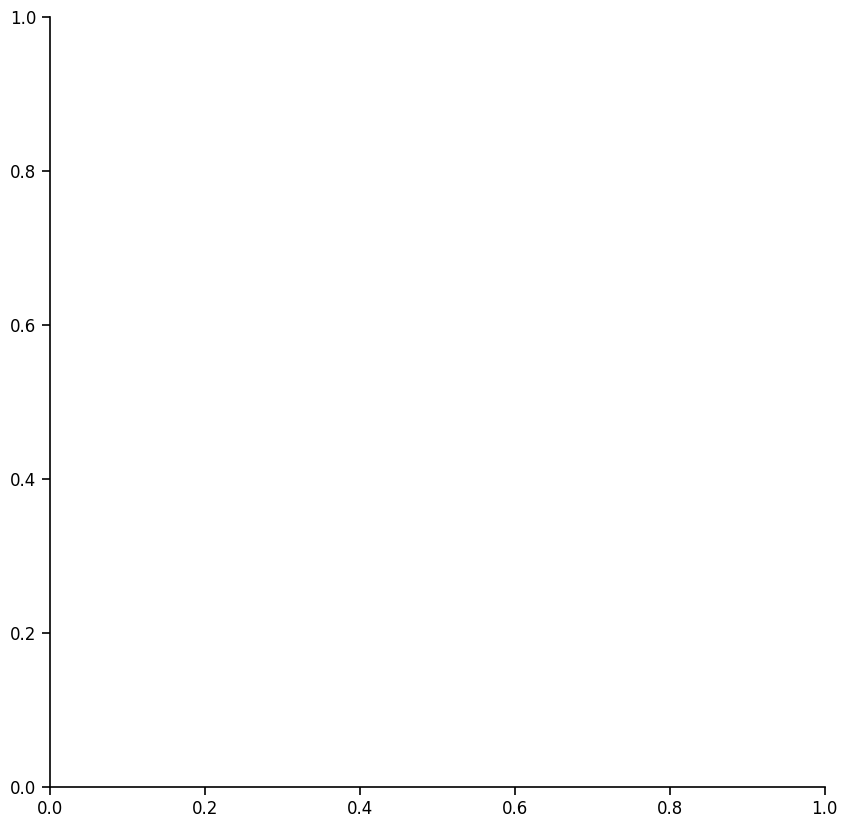

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.scatter(trend, firing_rate, s=100, c='k')
ax.set_xlabel('Vm baseline trend')
ax.set_ylabel('Firing rate (Hz)')
plt.show()

In [ ]:
%matplotlib inline
plot_spike_histograms(spike_results)